In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

In [3]:
wine_quality = fetch_ucirepo(id=186)

# Pre-processing
df = wine_quality.data.original


def categorize_quality(quality):
    if quality < 7:
        return 'bad'
    else:
        return 'good'


df['quality_category'] = df['quality'].apply(categorize_quality)

red = df[df['color'] == 'red']
white = df[df['color'] == 'white']

df_array = [red, white, df]
wine_names = ['red', 'white', 'red and white']

In [ ]:
df_names = ['Red Wine', 'White Wine', 'Combined Wine']


def confusion_matrix_plot(y_test, y_pred, clf, model):
    # Create both normalized and raw confusion matrices
    cm_raw = confusion_matrix(y_test, y_pred)
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize by true class
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Raw counts confusion matrix
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=clf.classes_)
    disp1.plot(cmap=plt.cm.Blues, ax=ax1, values_format='d')
    ax1.set_title(f'Confusion Matrix (Raw Counts)\n{model.__class__.__name__}')
    
    # Normalized confusion matrix (shows percentages for each true class)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=clf.classes_)
    disp2.plot(cmap=plt.cm.Blues, ax=ax2, values_format='.2f')
    ax2.set_title(f'Confusion Matrix (Normalized)\n{model.__class__.__name__}')
    
    plt.tight_layout()
    plt.show()


def optimized_folds(model, X, y):
    best_score = 0
    best_folds = 0

    for folds in np.arange(2, 11):
        scores = cross_val_score(model, X, y, cv=folds, scoring='f1_macro')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_folds = folds

    print(f"Best Folds: {best_folds} | Best Score: {best_score}")
    return best_folds


def pr_curve(y_test, y_scores, model):
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label='good')
    
    ap_score = average_precision_score(y_test, y_scores, pos_label='good') # avg precision score
    
    baseline = len(y_test[y_test == 'good']) / len(y_test) # random guess baseline
    
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {ap_score:.3f})')
    plt.axhline(y=baseline, color='red', linestyle='--', linewidth=1, label=f'Random Baseline (AP = {baseline:.3f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve for {model.__class__.__name__}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # text box with key metrics
    textstr = f'Average Precision: {ap_score:.3f}\nBaseline: {baseline:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return ap_score


def get_probability_scores(model, X_test):
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_test) # For models that support probability prediction
        good_index = list(model.classes_).index('good')
        return probabilities[:, good_index]
    elif hasattr(model, 'decision_function'): # For models with decision function 
        return model.decision_function(X_test)
    else:
        predictions = model.predict(X_test) # Fallback: use predicted class as binary score (not ideal for PR curve)
        return (predictions == 'good').astype(int)

    
def roc_curve_plot(y_test, y_scores, model):
    fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label='good')

    auc_score = roc_auc_score(y_test, y_scores)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve for {model.__class__.__name__}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.show()

Processing Red Wine DataFrame
Best Folds: 4 | Best Score: 0.6756418248528234
              precision    recall  f1-score   support

         bad       0.88      0.98      0.93       273
        good       0.71      0.26      0.38        47

    accuracy                           0.88       320
   macro avg       0.80      0.62      0.65       320
weighted avg       0.86      0.88      0.85       320

Best Folds: 4 | Best Score: 0.6756418248528234
              precision    recall  f1-score   support

         bad       0.88      0.98      0.93       273
        good       0.71      0.26      0.38        47

    accuracy                           0.88       320
   macro avg       0.80      0.62      0.65       320
weighted avg       0.86      0.88      0.85       320



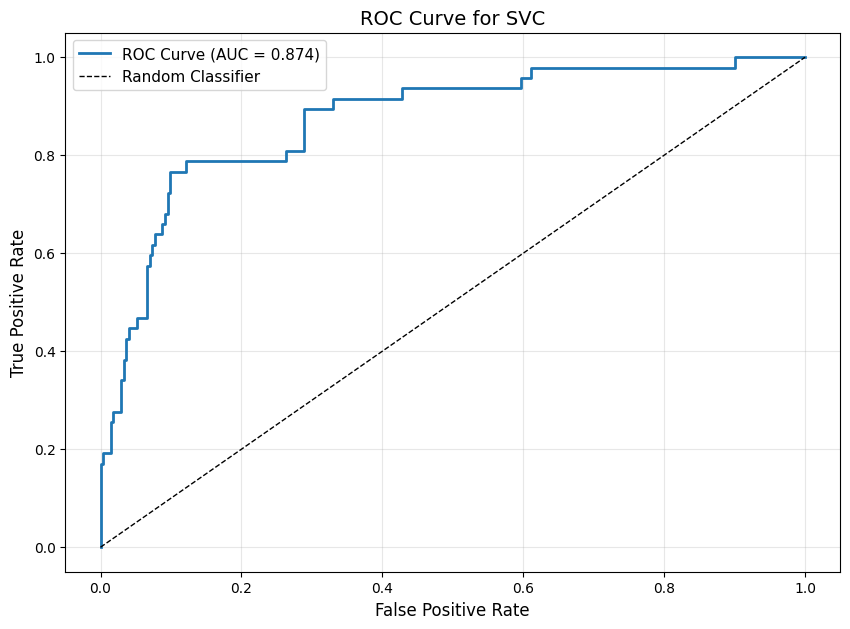

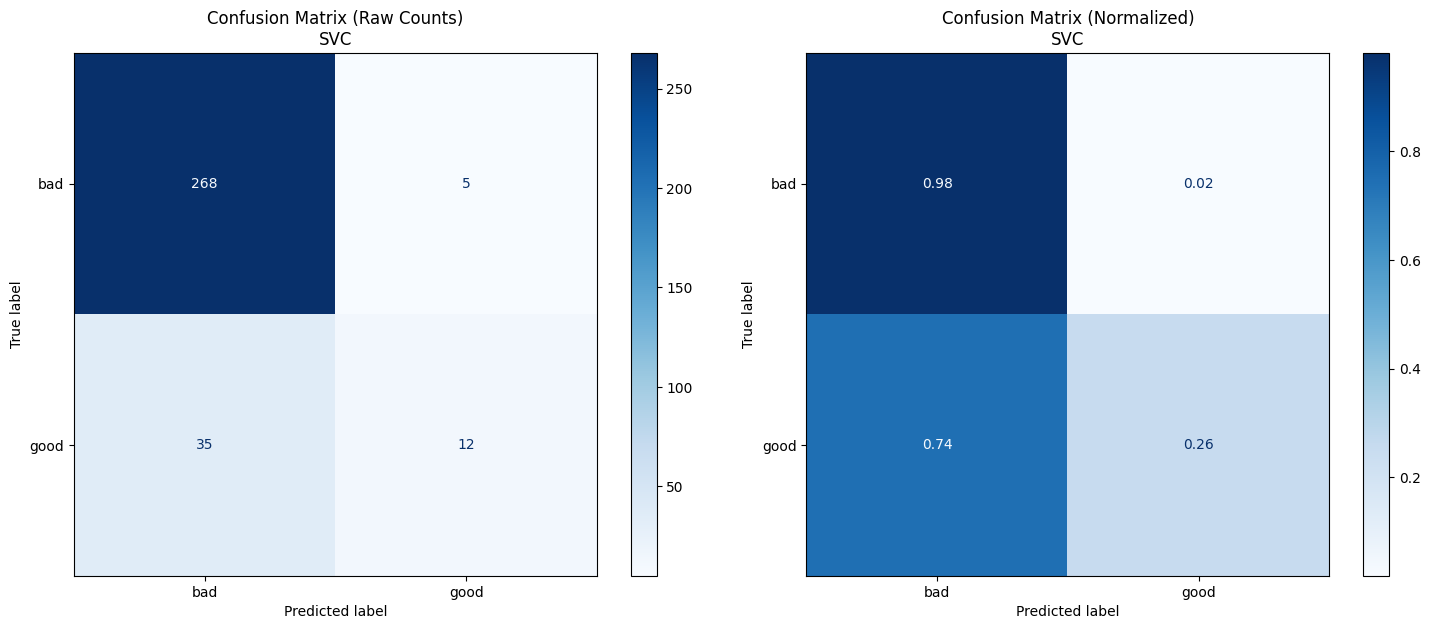



Processing White Wine DataFrame
Best Folds: 9 | Best Score: 0.6691323044434092
Best Folds: 9 | Best Score: 0.6691323044434092
              precision    recall  f1-score   support

         bad       0.83      0.97      0.89       753
        good       0.75      0.34      0.47       227

    accuracy                           0.82       980
   macro avg       0.79      0.65      0.68       980
weighted avg       0.81      0.82      0.79       980

              precision    recall  f1-score   support

         bad       0.83      0.97      0.89       753
        good       0.75      0.34      0.47       227

    accuracy                           0.82       980
   macro avg       0.79      0.65      0.68       980
weighted avg       0.81      0.82      0.79       980



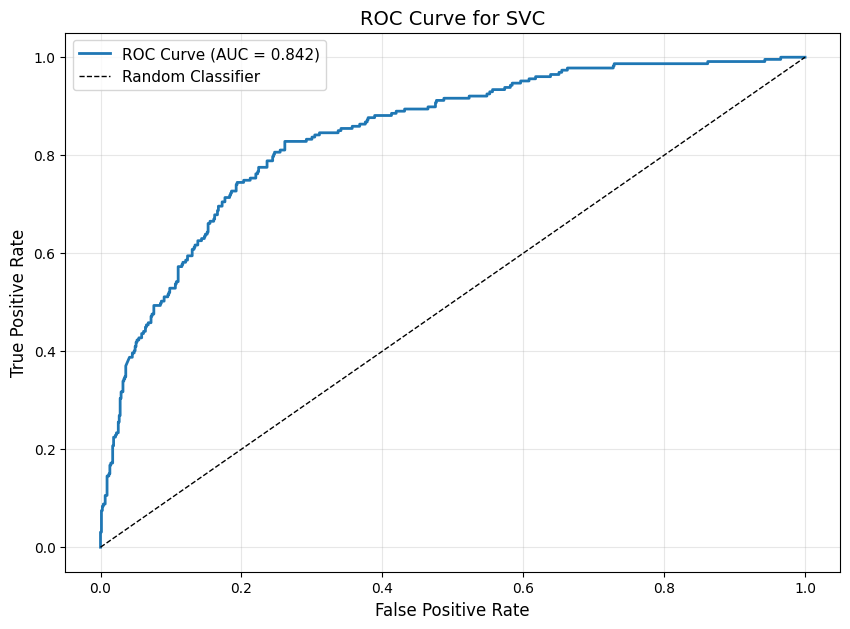

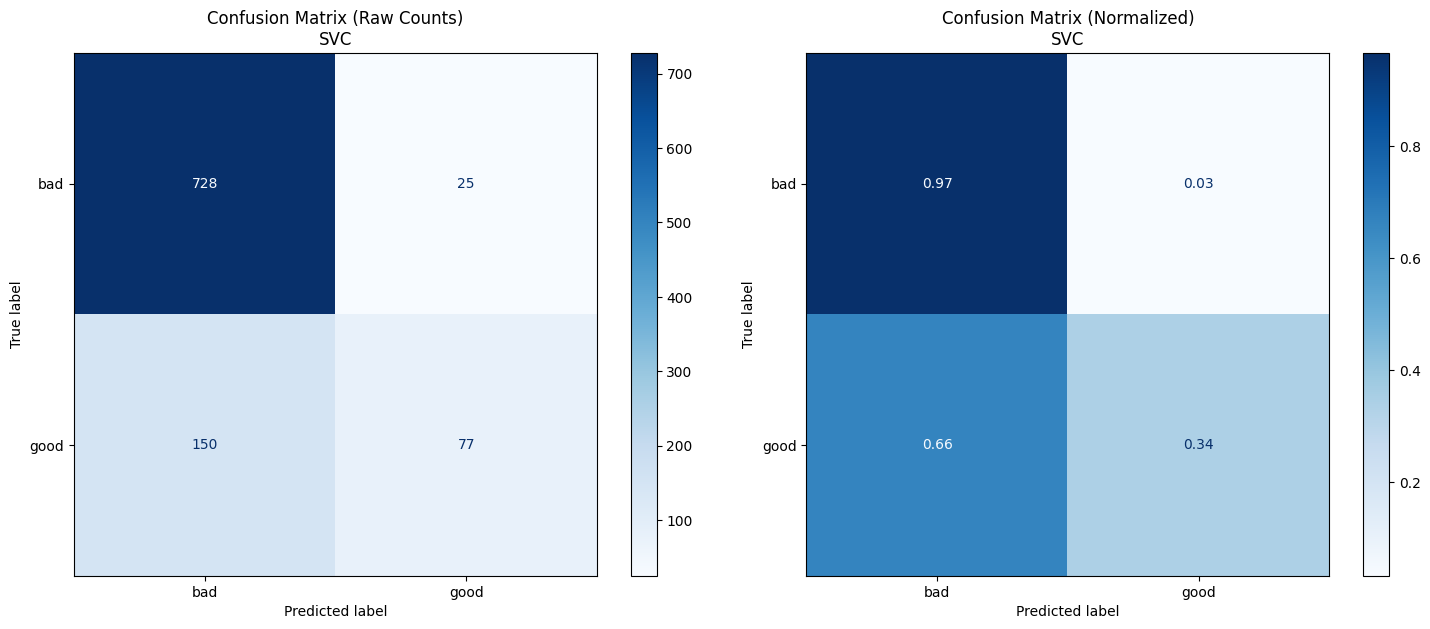



Processing Combined Wine DataFrame
Best Folds: 8 | Best Score: 0.6555323225153534
Best Folds: 8 | Best Score: 0.6555323225153534
              precision    recall  f1-score   support

         bad       0.85      0.97      0.91      1048
        good       0.71      0.27      0.39       252

    accuracy                           0.84      1300
   macro avg       0.78      0.62      0.65      1300
weighted avg       0.82      0.84      0.81      1300

              precision    recall  f1-score   support

         bad       0.85      0.97      0.91      1048
        good       0.71      0.27      0.39       252

    accuracy                           0.84      1300
   macro avg       0.78      0.62      0.65      1300
weighted avg       0.82      0.84      0.81      1300



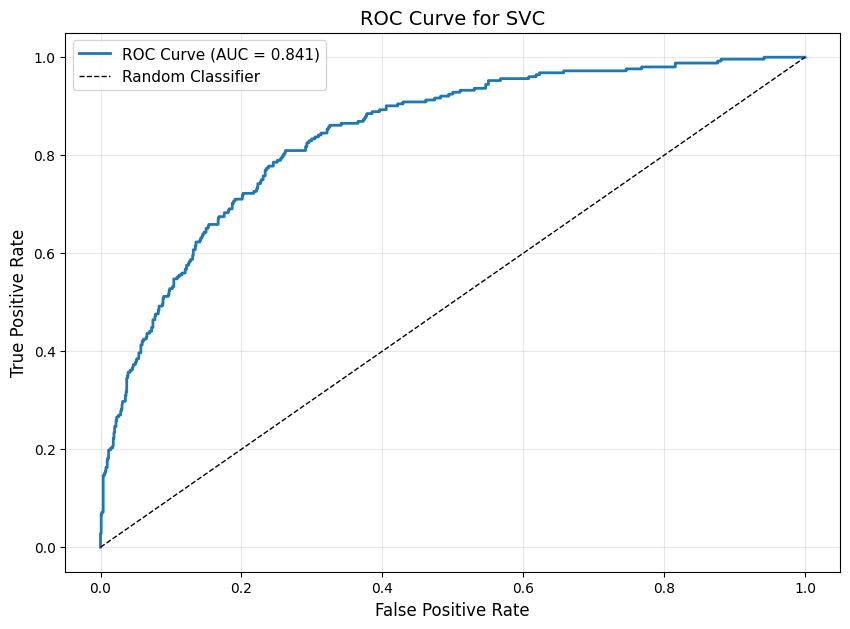

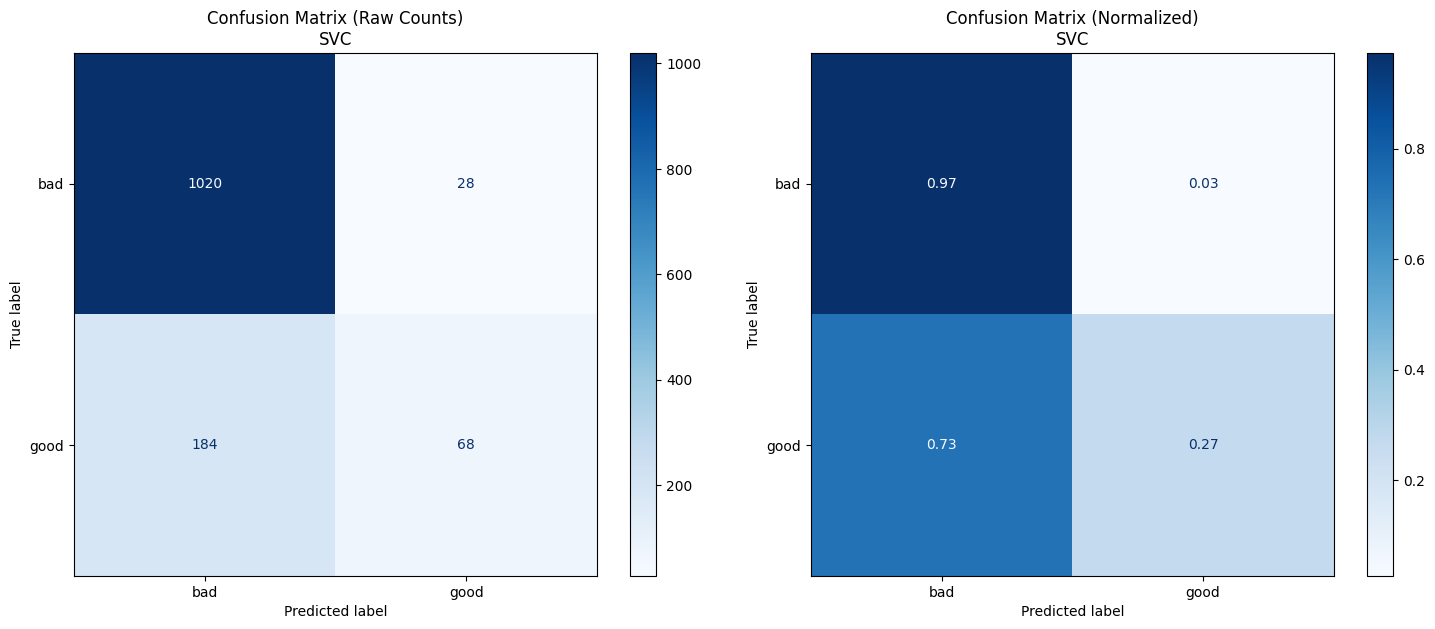

In [4]:
for i, wine in enumerate(df_array):
    print("=" * 40)
    print(f"Processing {df_names[i]} DataFrame")
    print("=" * 40)
    
    X = wine.drop(['quality', 'quality_category', 'color'], axis=1)
    y = wine['quality_category']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.2)

    # Enable probability estimates for ROC curve
    best_folds = optimized_folds(SVC(kernel='rbf', probability=True), X_train, y_train)
    svm = SVC(random_state=42, kernel='rbf', probability=True)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    y_scores = get_probability_scores(svm, X_test)
    # ap_score = pr_curve(y_test, y_scores, svm)
    roc_curve_plot(y_test, y_scores, svm)

    confusion_matrix_plot(y_test, y_pred, svm, svm)
    print("\n")

In [ ]:
for i, wine in enumerate(df_array):
    print("=" * 40)
    print(f"Processing {df_names[i]} DataFrame")
    print("=" * 40)
    
    X = wine.drop(['quality', 'quality_category', 'color'], axis=1)
    y = wine['quality_category']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.2)
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Enable probability estimates for ROC curve
    best_folds = optimized_folds(SVC(kernel='rbf', probability=True), X_train, y_train)
    svm = SVC(random_state=42, kernel='rbf', probability=True)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    y_scores = get_probability_scores(svm, X_test)
    # ap_score = pr_curve(y_test, y_scores, svm)
    roc_curve_plot(y_test, y_scores, svm)

    confusion_matrix_plot(y_test, y_pred, svm, svm)
    print("\n")

🚀 Starting Model Comparison...
🍷 Training All Models on Combined Wine Dataset

🔄 Training Models...
  Training KNN...
  Training Decision Tree...
  Training Random Forest...
  Training Decision Tree...
  Training Random Forest...
  Training QDA...
  Training SVM...
  Training QDA...
  Training SVM...

📊 Creating ROC Curve Comparison...

📊 Creating ROC Curve Comparison...


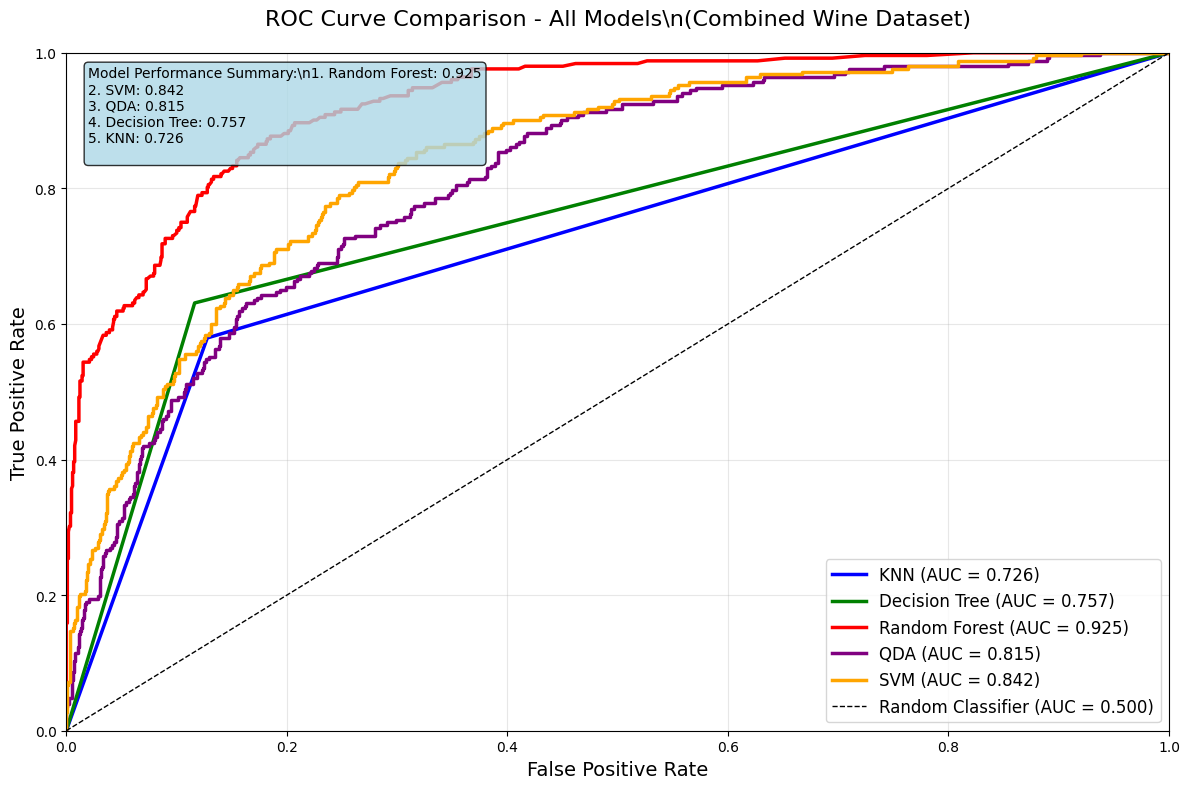


DETAILED MODEL COMPARISON RESULTS

1. Random Forest:
   AUC Score: 0.9249
   Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}

2. SVM:
   AUC Score: 0.8416

3. QDA:
   AUC Score: 0.8146

4. Decision Tree:
   AUC Score: 0.7573

5. KNN:
   AUC Score: 0.7258
   Best Parameters: {'n_neighbors': 1}

📈 Performance Analysis:
   Best Model: Random Forest (AUC = 0.9249)
   Performance Gaps:
     SVM: -0.0834 (9.0% worse)
     QDA: -0.1104 (11.9% worse)
     Decision Tree: -0.1677 (18.1% worse)
     KNN: -0.1992 (21.5% worse)


In [ ]:
# Comprehensive ROC Curve Comparison for All Models
def compare_all_models_roc():
    """
    Train all models on combined wine dataset and compare their ROC curves
    """
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    from sklearn.model_selection import GridSearchCV
    from collections import defaultdict
    
    # Use combined wine dataset (index 2)
    combined_wine = df_array[2]
    X = combined_wine.drop(['quality', 'quality_category', 'color'], axis=1)
    y = combined_wine['quality_category']
    
    print("🍷 Training All Models on Combined Wine Dataset")
    print("=" * 60)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    
    # Scale data for SVM (and optionally for other models)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Store results for plotting
    models_results = {}
    
    print("\n🔄 Training Models...")
    
    # 1. KNN
    print("  Training KNN...")
    knn_param_grid = {'n_neighbors': range(1, 21)}
    knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='f1_macro')
    knn_grid.fit(X_train, y_train)
    knn_best = knn_grid.best_estimator_
    
    y_scores_knn = get_probability_scores(knn_best, X_test)
    models_results['KNN'] = {
        'model': knn_best,
        'scores': y_scores_knn,
        'best_params': knn_grid.best_params_
    }
    
    # 2. Decision Tree
    print("  Training Decision Tree...")
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    
    y_scores_dt = get_probability_scores(dt, X_test)
    models_results['Decision Tree'] = {
        'model': dt,
        'scores': y_scores_dt,
        'best_params': {}
    }
    
    # 3. Random Forest
    print("  Training Random Forest...")
    rf_param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    from sklearn.model_selection import RandomizedSearchCV
    rf_random = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                                   rf_param_dist, cv=5, n_iter=10, 
                                   scoring='f1_macro', random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)
    rf_best = rf_random.best_estimator_
    
    y_scores_rf = get_probability_scores(rf_best, X_test)
    models_results['Random Forest'] = {
        'model': rf_best,
        'scores': y_scores_rf,
        'best_params': rf_random.best_params_
    }
    
    # 4. QDA
    print("  Training QDA...")
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train, y_train)
    
    y_scores_qda = get_probability_scores(qda, X_test)
    models_results['QDA'] = {
        'model': qda,
        'scores': y_scores_qda,
        'best_params': {}
    }
    
    # 5. SVM
    print("  Training SVM...")
    svm = SVC(random_state=42, kernel='rbf', probability=True)
    svm.fit(X_train_scaled, y_train)
    
    y_scores_svm = get_probability_scores(svm, X_test_scaled)
    models_results['SVM'] = {
        'model': svm,
        'scores': y_scores_svm,
        'best_params': {}
    }
    
    print("\n📊 Creating ROC Curve Comparison...")
    
    # Create the comparison plot
    plt.figure(figsize=(12, 8))
    
    # Define colors for each model
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    # Store AUC scores for summary
    auc_scores = {}
    
    # Plot ROC curve for each model
    for i, (model_name, result) in enumerate(models_results.items()):
        y_scores = result['scores']
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label='good')
        auc_score = roc_auc_score(y_test, y_scores)
        
        auc_scores[model_name] = auc_score
        
        # Plot
        plt.plot(fpr, tpr, linewidth=2.5, color=colors[i], 
                label=f'{model_name} (AUC = {auc_score:.3f})')
    
    # Add random classifier line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.500)')
    
    # Customize plot
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve Comparison - All Models\\n(Combined Wine Dataset)', fontsize=16, pad=20)
    plt.legend(fontsize=12, loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

# Run the comparison
print("🚀 Starting Model Comparison...")
compare_all_models_roc()